# GRU Search-Space Analysis

In [1]:
from __future__ import print_function

import os

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata

## Hyperparameters

In [2]:
LOG_DIR = './population_backup/storage/experiment6/'

## Data

### Fetch

In [3]:
# Setup the header
head = ['bias_r', 'bias_z', 'bias_h',
        'weight_xr', 'weight_xz', 'weight_xh',
        'weight_hr', 'weight_hz', 'weight_hh',
        'bias_rw', 'conn0', 'conn1', 'conn2']

In [4]:
# Check if tsv files already exist
raw_path = os.path.join(LOG_DIR, f'topology_3/data/topology_3.csv')  # Solutions
raw_path2 = os.path.join(LOG_DIR, f'topology_30/data/topology_30.csv')  # Randomly sampled

# Load in the data (without header)
raw = np.genfromtxt(raw_path, delimiter=',')[1:]
raw2 = np.genfromtxt(raw_path2, delimiter=',')[1:]
raw_combined = np.concatenate((raw, raw2))
data = raw_combined[:,:-1]
meta = raw_combined[:,-1]

# Print shape:
print(f"Data shape: {data.shape}")
print(f"Meta shape: {meta.shape}")

Data shape: (346048, 13)
Meta shape: (346048,)


In [5]:
# Transform to pandas dataframe (easier to manipulate)
data_pd = pd.DataFrame(data, columns=head)
meta_pd = pd.DataFrame(meta, columns=['fitness'])
data_pd.head()

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,bias_rw,conn0,conn1,conn2
0,-2.654714,2.378201,0.524675,3.505099,-0.555603,0.958105,-2.423341,-4.700958,-0.579677,2.258131,-1.591773,-2.661706,-3.176652
1,-2.654714,2.378201,0.524675,3.551858,-0.555603,0.958105,-2.423341,-4.700958,-0.198581,2.258131,-1.591773,-2.661706,-3.176652
2,-2.654714,2.378201,0.524675,3.505099,-0.555603,0.958105,-2.423341,-4.700958,-0.579677,2.258131,-1.591773,-2.661706,-3.176652
3,-2.877392,2.456087,0.524675,-4.081224,-0.241180,0.958105,0.909630,-4.551147,-0.791267,2.258131,-1.591773,-2.810586,-3.181079
4,-1.365733,2.456087,0.524675,-4.081224,-0.079437,0.958105,1.124392,-4.551147,-0.579677,2.258131,-1.591773,-3.298439,-3.176652


### Filter

In [6]:
# Filter out the duplicates
indices = data_pd.duplicated()
data_pd = data_pd[~indices.values]
meta_pd = meta_pd[~indices.values]
print(f"Data shape: {data_pd.shape}")
print(f"Meta shape: {meta_pd.shape}")

Data shape: (304470, 13)
Meta shape: (304470, 1)


In [7]:
# For example, if you want to see only fitnesses of 1 (perfect score).
indices = meta_pd == 1
data_pd_sol = data_pd.copy()
meta_pd_sol = meta_pd.copy()
data_pd_sol = data_pd_sol[indices.values]
meta_pd_sol = meta_pd_sol[indices.values]
print(f"Data shape: {data_pd_sol.shape}")
print(f"Meta shape: {meta_pd_sol.shape}")

Data shape: (13441, 13)
Meta shape: (13441, 1)


### Visualize the solution space

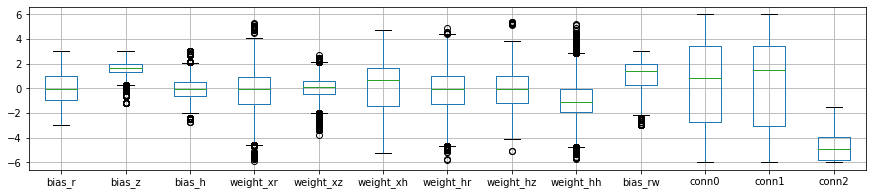

In [8]:
plt.figure(figsize=(15,3))
data_pd_sol.boxplot()
plt.show()
plt.close()

In [9]:
COLORS = ['#ffffff', sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3]]

def compare(h, t):
    plt.figure(figsize=(3,3))
    gs1 = gridspec.GridSpec(5,1)
    gs1.update(wspace=0, hspace=0)
    for i in sorted([i for i in range(5)], reverse=True):
        plt.subplot(gs1[i])
        if i == 0: plt.title(t)

        # Format data
        if i == 0:
            data_temp = data_pd_sol
        elif i == 1:
            indices = (data_pd_sol['conn0'] >= 0) & (data_pd_sol['conn1'] >= 0)
            data_temp = data_pd_sol[indices.values]
        elif i == 2:
            indices = (data_pd_sol['conn0'] >= 0) & (data_pd_sol['conn1'] < 0)
            data_temp = data_pd_sol[indices.values]
        elif i == 3:
            indices = (data_pd_sol['conn0'] < 0) & (data_pd_sol['conn1'] >= 0)
            data_temp = data_pd_sol[indices.values]
        else:
            indices = (data_pd_sol['conn0'] < 0) & (data_pd_sol['conn1'] < 0)
            data_temp = data_pd_sol[indices.values]        

        # Create the plot
        sns.violinplot(data_temp[h], color=COLORS[i])
        if 'bias' in h:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
        plt.yticks([])
        plt.xlabel('')
        if i < 4: 
            plt.gca().set_xticklabels([])
    plt.savefig(f"delete_me/{h}.png", bbox_inches='tight', pad_inches=0.02)
    plt.savefig(f"delete_me/{h}.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
    plt.show()
    plt.close()

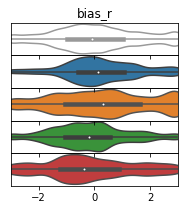

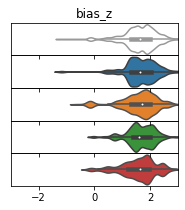

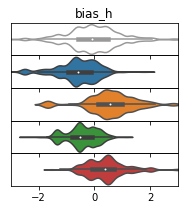

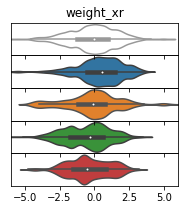

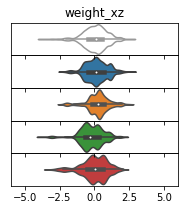

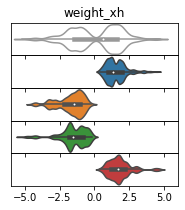

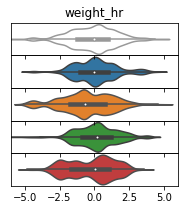

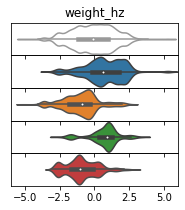

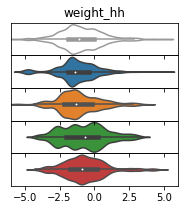

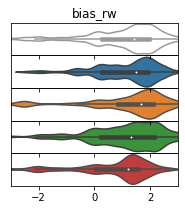

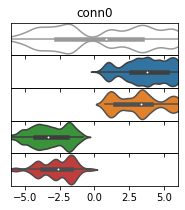

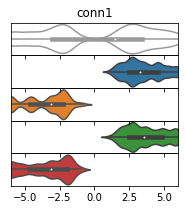

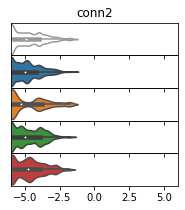

In [10]:
for h in head:
    compare(h,h)

### Classify

In [11]:
def classify_connections(r):
    if r['conn0'] >= 0 and r['conn1'] >= 0:
        return "PP"  # Positive Positive
    elif r['conn0'] >= 0 and r['conn1'] < 0:
        return "PN"  # Positive Negative
    elif r['conn0'] < 0 and r['conn1'] >= 0:
        return "NP"  # Negative Positive
    else:
        return "NN"  # Negative Negative

In [12]:
data_pd_sol['classes'] = data_pd_sol.apply(lambda row: classify_connections(row), axis=1).values
data_pd_sol.head()

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,bias_rw,conn0,conn1,conn2,classes
150,1.379528,1.284594,-1.318545,2.005841,1.142604,1.14685,1.289321,-1.627283,-2.057124,2.420804,4.512758,4.153022,-4.971565,PP
151,1.379528,1.284594,-1.318545,1.986390,1.142604,1.14685,1.289321,-1.627283,-2.057124,2.420804,4.512758,4.153022,-4.971565,PP
152,1.379528,1.284594,-1.318545,2.005841,1.246766,1.14685,1.289321,-1.627283,-2.057124,2.420804,4.512758,4.153022,-4.971565,PP
153,1.379528,1.284594,-1.318545,2.005841,1.142604,1.14685,1.289321,-1.780278,-2.057124,2.420804,4.512758,4.153022,-4.971565,PP
155,1.379528,1.284594,-1.318545,2.005841,1.142604,1.14685,1.355030,-1.780278,-2.029475,2.420804,4.512758,4.153022,-4.971565,PP


## PCA

### Complete search space

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_pd_sol[head].values)
data_pd_sol['pca-one'] = pca_result[:,0]
data_pd_sol['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.31893906 0.27262021]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


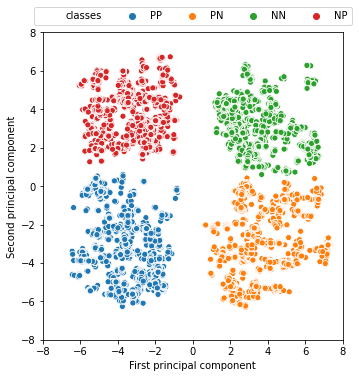

In [14]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="classes",
    palette="tab10",
    data=data_pd_sol,
)
plt.tight_layout()
leg = plt.legend(loc='upper center',
                 bbox_to_anchor=(0.5, 1.1),
                 fancybox=True,
                 fontsize=10,
                 ncol=5)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig(f"delete_me/pca_gru_sol_full.png", bbox_inches='tight', pad_inches=0.02)
plt.savefig(f"delete_me/pca_gru_sol_full.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

In [25]:
leg.labels

AttributeError: 'Legend' object has no attribute 'labels'

## PP only

### Data

In [15]:
data_pd_pp = data_pd.copy()
meta_pd_pp = meta_pd.copy()
indices = (data_pd_pp['conn1'] >= 0) & (data_pd_pp['conn0'] >= 0)
data_pd_pp = data_pd_pp[indices.values]
meta_pd_pp = meta_pd_pp[indices.values]
print(f"Data shape: {data_pd_pp.shape}")
print(f"Meta shape: {meta_pd_pp.shape}")

Data shape: (82480, 13)
Meta shape: (82480, 1)


In [16]:
# Prune out the worst
indices = meta_pd_pp >= 0.  # At least three targets found
data_pd_pp = data_pd_pp[indices.values]
meta_pd_pp = meta_pd_pp[indices.values]
print(f"Data shape: {data_pd_pp.shape}")
print(f"Meta shape: {meta_pd_pp.shape}")

Data shape: (82480, 13)
Meta shape: (82480, 1)


In [17]:
data_pd_pp_sol = data_pd_pp.copy()
meta_pd_pp_sol = meta_pd_pp.copy()
indices = meta_pd_pp_sol == 1
data_pd_pp_sol = data_pd_pp_sol[indices.values]
meta_pd_pp_sol = meta_pd_pp_sol[indices.values]
print(f"Data shape: {data_pd_pp_sol.shape}")
print(f"Meta shape: {meta_pd_pp_sol.shape}")

Data shape: (3736, 13)
Meta shape: (3736, 1)


### Visualize solution space

In [18]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_pd_pp_sol[head].values)
data_pd_pp_sol['pca-one'] = pca_result[:,0]
data_pd_pp_sol['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.29357354 0.16099949]


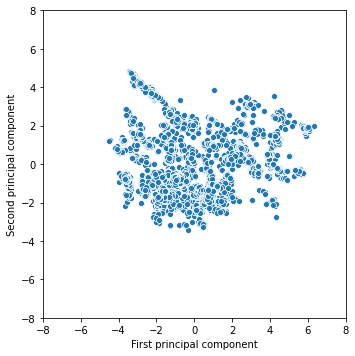

In [19]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    data=data_pd_pp_sol,
)
plt.tight_layout()
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig(f"delete_me/pca_gru_pp_sol.png", bbox_inches='tight', pad_inches=0.02)
plt.savefig(f"delete_me/pca_gru_pp_sol.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

### Visualize search space

In [20]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_pd_pp[head].values)
data_pd_pp['pca-one'] = pca_result[:,0]
data_pd_pp['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.31980933 0.09325969]


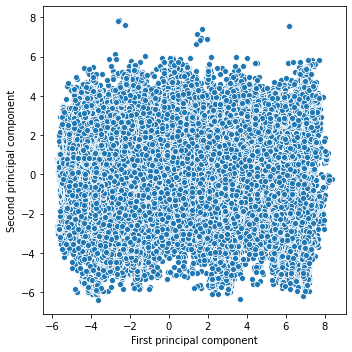

In [21]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    data=data_pd_pp,
)
plt.tight_layout()
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig(f"delete_me/pca_gru_pp_sol.png", bbox_inches='tight', pad_inches=0.02)
plt.savefig(f"delete_me/pca_gru_pp_sol.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

In [22]:
indices = (data_pd_pp['pca-one'] >= -6) & (data_pd_pp['pca-one'] <= 6) & (data_pd_pp['pca-two'] >= -6) & (data_pd_pp['pca-one'] <= 6)
data_pd_pp = data_pd_pp[indices.values]
meta_pd_pp = meta_pd_pp[indices.values]
print(f"Data shape: {data_pd_pp.shape}")
print(f"Meta shape: {meta_pd_pp.shape}")

Data shape: (75297, 15)
Meta shape: (75297, 1)


In [23]:
grid_x, grid_y = np.mgrid[-6:6:0.01, -6:6:0.01]
knn_data = griddata(data_pd_pp[['pca-one', 'pca-two']].values,
                    meta_pd_pp.values[:,0],
                    (grid_x, grid_y),
                    method='nearest')

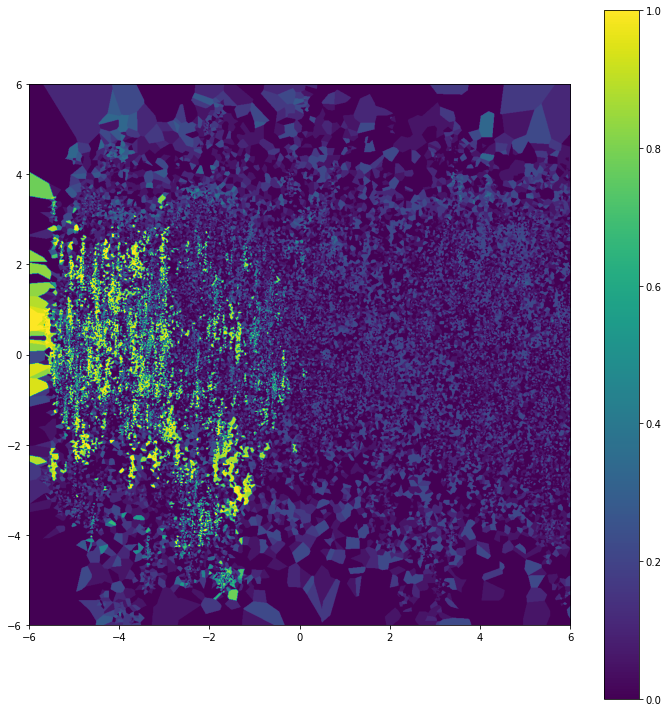

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(knn_data.T, extent=(-6,6,-6,6), origin='lower')
plt.colorbar()
plt.tight_layout()
plt.show()
# plt.savefig(f"{path}reset_gate.png")
plt.close()